# Drivers

The word "driver" is an OpenMDAO specific term that refers to something that operates on a workflow.  The most simple driver is something that simply executes an entire workflow once.  For optimization, a driver is usually an optimization algorithm that iterates over the workflow until (ideally) an optimal solution is found.  In a very complex workflow and problem formulation, there may be multiple drivers acting on sub-groups of a workflow.  For instance, in an optimization under uncertainty (OUU) problem, there is usually an uncertainty quantification / analysis driver operating on a workflow nested within a larger optimization workflow.

In this tutorial, a basic introduction to drivers is provided that focuses on some of the most commonly used drivers in Topfarm.  These include examples of four types of drivers:
* Design of Experiments (DoE) - these drivers sample across a set of input parameters and execute the workflow for each input set. Such drivers can be parallelized easily since each workflow execution is independent from the next.
* Gradient-based or local search optimizers - these drivers use information about the gradients of the objective function for the problem with respect to the design variables in order to move through the design space systematically to find an improved design. This class of optimization algorithms are efficient but are challenged problems that contain significant nonconvexity, objective functions that are relatively insensitive to the design variables, and other issues.
* Gradient-free metaheuristic optimizers - these drivers typically use "nature-inspired" algorithms to search the design space more globally. They use multiple instances of designs at once and compare performance to make decisions about how to generate new designs that hopefully improve the objective function performance. A clasic example of this type of optimizer is a genetic algorithm.
* Gradient-free heuristic optimizers - these drivers use some sort of heuristic to search through the design space that is informed by domain knowledge and experience with some element of randomness as well. Random search algorithms fall into this category and are widely used in commercial wind farm optimization.

We will introduce a specific example of each of the above driver types applied to a Topfarm problem in the next sequence of examples.

**First we import supporting libraries in Python numpy and matplotlib**

In [1]:
from topfarm.easy_drivers import EasyDriverBase
EasyDriverBase.max_iter = 1

In [2]:
import numpy as np
%matplotlib inline
# uncomment to update plot during optimization
# %matplotlib qt
import matplotlib.pyplot as plt

**Next we import and initialize several functions and classes from Topfarm to set up the problem including:**
* **TopFarmProblem - overall topfarm problem class to which the objectives, design variables, and constraints are added**
* **XYBoundaryConstraint - for a boundary specified as a series of connected perimeter vertices**
* **CircleBoundaryConstraint - for a circular boundary with a central location and a radius**
* **SpacingConstraint - for the inter-turbine spacing distance constraints**

**We also import some dummy models (DummyCost, NoPlot, DummyCostPlotComp) as stand-ins for what would be the actual models used in a real wind farm design problem. The dummy cost model takes user defined input for an initial and optimal state and computes the sum of squared error between the two.**

**For documentation on Topfarm see:**
https://topfarm.pages.windenergy.dtu.dk/TopFarm2/user_guide.html#

In [3]:
from topfarm.cost_models.dummy import DummyCost
from topfarm.plotting import NoPlot
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm._topfarm import TopFarmProblem
from topfarm.cost_models.dummy import DummyCostPlotComp

**Next we do some problem set up to provide an initial and optimal turbine layout as well as the overall turbine location boundary.**

**We also configure initalize the plotting component for use in the optimization.**

In [4]:
initial = np.array([[6, 0, 0], [6, -8, 0], [1, 1, 0]])  # user-defined initial turbine layouts
boundary = np.array([(0, 0), (6, 0), (6, -10), (0, -10)])  # user-defined site boundary vertices
optimal = np.array([[3, -3, 1], [7, -7, 2], [4, -3, 4]])  # user-defined optimal turbine layouts

plot_comp = DummyCostPlotComp(optimal, delay=0.1, plot_improvements_only=True)

**A function is introduced below that will allow us to quickly reconfigure the example for the different drivers.**

In [5]:
def optimize(driver):
    tf = TopFarmProblem(
            dict(zip('xy', (initial[:, :2]).T)), # setting up the turbines as design variables
            DummyCost(optimal[:, :2]), # using dummy cost model
            constraints=[SpacingConstraint(2), # spacing constraint set up for minimum inter-turbine spacing
                         XYBoundaryConstraint(boundary)], # constraint set up for the boundary type provided
            driver=driver, # driver is specified for the example
            plot_comp=plot_comp) # support plotting function
    tf.optimize() # run the DoE analysis or optimization


## DOE (Design Of Experiment) Driver

The first driver example executes a design of experiments looking at how different sets of inputs for the turbine positions affect the cost function.  In the first case, a user-defined set of inputs is provided, while in the second a "full-factorial" sampling approach is used.

(Wikipedia) "In statistics, a full factorial experiment is an experiment whose design consists of two or more factors, each with discrete possible values or "levels", and whose experimental units take on all possible combinations of these levels across all such factors. A full factorial design may also be called a fully crossed design. Such an experiment allows the investigator to study the effect of each factor on the response variable, as well as the effects of interactions between factors on the response variable."

**Set up a DoE experiment example using a user-defined set up input combinations of the 3 turbine positions**

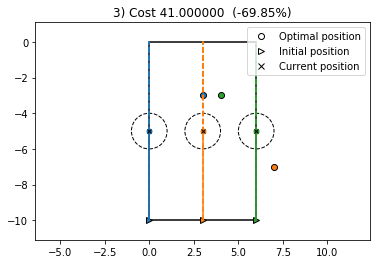

In [10]:
from openmdao.drivers.doe_generators import ListGenerator
from openmdao.drivers.doe_driver import DOEDriver

optimize(DOEDriver(ListGenerator([[('x', [0., 3., 6.]), ('y', [-10., -10., -10.])],
                                  [('x', [0., 3., 6.]), ('y', [-5., -5., -5.])],
                                  [('x', [0., 3., 6.]), ('y', [-0., -0., -0.])],
                                  ])))

**Run a full factorial experiment for two inputs using OpenMDAO's built-in FullFactorialGenerator class. The input value of 2 is "the number of evenly spaced levels between each design variable lower and upper bound."**

**See: http://openmdao.org/twodocs/versions/latest/_srcdocs/packages/drivers/doe_generators.html**
**for more information on the various built-in DoE drivers for OpenMDAO.**

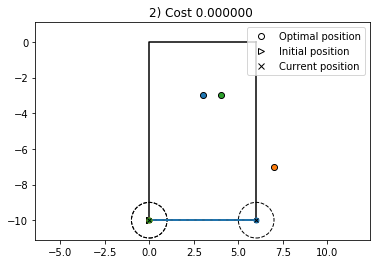

In [11]:
from openmdao.drivers.doe_generators import FullFactorialGenerator, ListGenerator
from openmdao.drivers.doe_driver import DOEDriver

optimize(DOEDriver(FullFactorialGenerator(3))) # full factorial sampling with 2 levels (2 is the default)

### Exercise

**Update the number of levels of the full factorial to see how it affects the sampling of the design space.**

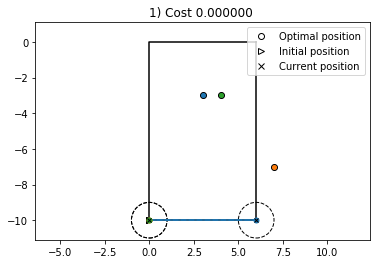

In [13]:
optimize(DOEDriver(FullFactorialGenerator(2)))

## Gradient-Based Optimization with ScipyOptimizeDriver

In the next example we introduce gradient-based optimization using a common open-source algorithm "sequential least squares quadratic programming" or SLSQP. OpenMDAO has several built-in drivers that leverage libraries of opensource optimization algorithms including those from SciPy and PyOptSparse.  For more information on the optimization drivers available in OpenMDAO, see: http://openmdao.org/twodocs/versions/latest/_srcdocs/packages/openmdao.drivers.html

Note that in Topfarm, the OpenMDAO drivers are wrapped so that you can more easily use them on Topfarm wind farm design optimization probblems.

**Import the Topfarm implementation of the Scipy optimizer and execute a gradient-based optimization.**

Optimization FAILED.
Iteration limit exceeded
-----------------------------------


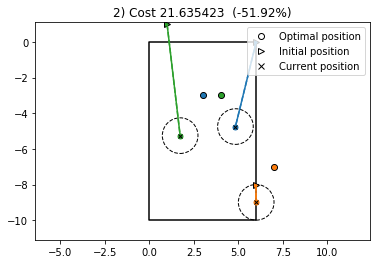

In [12]:
from topfarm.easy_drivers import EasyScipyOptimizeDriver
# Choose optimization driver SLSQP and set up key parameters for the optimization
# Maximum iterations maxiter sets the maximum number of iterations before stopping (unless an optimum is found prior)
# Tolerance tol sets the required tolerance for establishing convergence criteria of the optimziation
optimize(EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=200, tol=1e-6, disp=False))

**Note that the optimization converges much sooner than the maximum iterations of 200.**

### Exercise!!

**Adjust the optimal positions of the turbines and see how the optimization performs.**

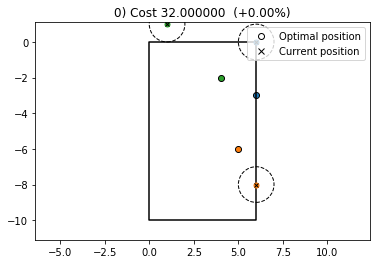

Optimization FAILED.
Iteration limit exceeded
-----------------------------------


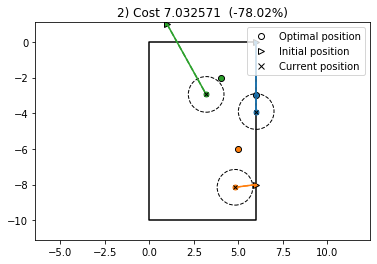

In [13]:
optimal = np.array([[6, -3, 1], [5, -6, 2], [4, -2, 4]])  # user-defined optimal turbine layouts

plot_comp = DummyCostPlotComp(optimal, delay=0.5, plot_improvements_only=True)

optimize(EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=200, tol=1e-6, disp=False))

Another popular optimization method in SciPy is COBYLA which is also a local-search method but not a gradient-based search since it does not assume the derivative is known.  Instead approximates the constrained optimization problem iteratively as a linear programming problem.

**Repeat the original optimization problem with the COBYLA optimization driver. Note how it does not respect the constraints of the boundary on every iteration.**

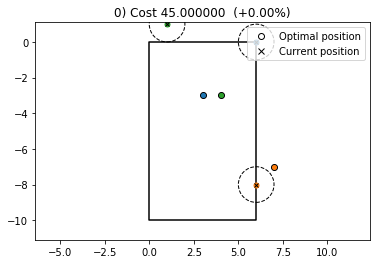

Optimization FAILED.
Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
-----------------------------------


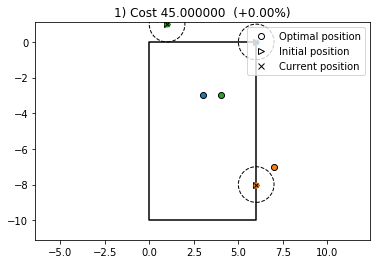

In [14]:
#set optimal back to original optimal
optimal = np.array([[3, -3, 1], [7, -7, 2], [4, -3, 4]])  # user-defined optimal turbine layouts

plot_comp = DummyCostPlotComp(optimal, delay=0.5, plot_improvements_only=True)

from topfarm.easy_drivers import EasyScipyOptimizeDriver
# Choose optimization driver COBYLA and set up key parameters for the optimization
# Maximum iterations maxiter sets the maximum number of iterations before stopping (unless an optimum is found prior)
# Tolerance tol sets the required tolerance for establishing convergence criteria of the optimziation
optimize(EasyScipyOptimizeDriver(optimizer='COBYLA', maxiter=200, tol=1e-6, disp=False))

## Genetic algorithm driver

The next examples uses a simple genetic algorithm metaheuristic optimization approach. Note how the global design space is more exhaustively explored by the GA. This more comprehensive exploration of the search space comes at the cost of much slower convergence to an optimal solution.

**Import the Topfarm implmentation of the GA driver and execute an optimization.**

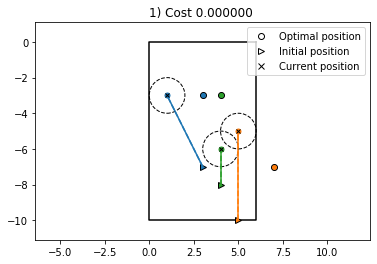

In [15]:
from topfarm.drivers.random_search_driver import RandomizeTurbinePosition_Circle
from topfarm.easy_drivers import EasySimpleGADriver
# Choose optimization driver GA and set up key parameters for the optimization
# Maximum generations max_gen sets the number of iterations for the optimization
# Population size pop_size sets the number of individuals in the population within each iteration
optimize(EasySimpleGADriver(max_gen=100, pop_size=5, Pm=None, Pc=.5, elitism=True, bits={}))

Even after 100 generations, there is a lack of convergence.  This shows clearly the advantages of gradient-based methods for smartly probing the design space.  However, gradient-based methods will often end up in "local optima" because their final converged solution depends heavily on their intial starting point in the design space.

## Random search driver

An example of a heuristic method (somewhere between gradient-based and metaheuristic methods) is random search.  Topfarm has implemented the Random Search algorithm based on the one developed at DTU Wind Energy by Ju Feng.  

More information about the method can be found here: https://www.sciencedirect.com/science/article/pii/S0960148115000129?via%3Dihub

In this case, the algorithm repositions turbines using a vector defined by an angle and amplitude that are randomly set at each iteration and the solution tested for improvement against the objective function.

**Set up optimization using Topfarm implementation of random search with turbine position circle method.**

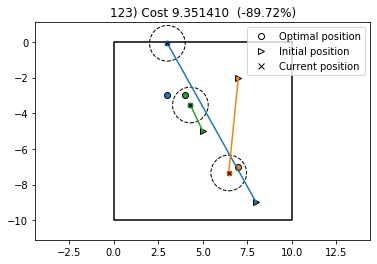

In [18]:
initial = np.array([[8, -9, 0], [7, -2, 0], [5, -5, 0]])  # user-defined initial turbine layouts
boundary = np.array([(0, 0), (10, 0), (10, -10), (0, -10)])  # user-defined site boundary vertices
optimal = np.array([[3, -3, 1], [7, -7, 2], [4, -3, 4]])  # user-defined optimal turbine layouts


from topfarm.drivers.random_search_driver import RandomizeTurbinePosition_Circle
from topfarm.easy_drivers import EasyRandomSearchDriver

# Set up key parameters of random search
# Maximum iterations max_iter sets the maximum number of iterations of the optimization
# Maximum time max_time limits execution time (so also limits the overall number of iterations)
# Maximum step max_step limits how much the design can change on a given iteration
optimize(EasyRandomSearchDriver(
    randomize_func=RandomizeTurbinePosition_Circle(max_step=5), 
    max_iter=100, 
    max_time=1000, 
    disp=False))

Note that the random search in this case is also slower to converge than the gradient-based solution. Random search and other heuristic methods, like metaheuristic methods, are more powerful with complex optimization problems with many local minima, concavities, flatness or other challenging features.